In [2]:
import numpy as np
import py21cmfast as p21c

from astropy.cosmology import Planck18, z_at_value
from astropy import units as u
from astropy.constants import c, k_B, m_p, e, m_e

from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy.special import gamma, erf
from scipy.optimize import minimize

In [3]:
import matplotlib.pyplot as plt
rc = {"font.family" : "serif", 
    "mathtext.fontset" : "stix"}
plt.rcParams.update(rc) 
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams.update({'font.size': 14})
plt.style.use('dark_background')
import matplotlib as mpl
label_size = 20
font_size = 30
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

In [4]:
# _, _, _, mh, _, sfr = np.load(f'./data/halo_fields/halo_field_5.0.npy')

# # compute 1500A UV magnitude
# sfr *= 3.1557e7
# kuv = 1.15e-28
# muv = 51.64 - 2.5*np.log10(sfr/kuv)

# # purge extremely dim galaxies
# mh = mh[muv<=-16]
# sfr = sfr[muv<=-16]
# muv = muv[muv<=-16]

Use the Schechter form for P(M_UV)

In [5]:
# from Bouwens 2021 https://arxiv.org/pdf/2102.07775
phi_5 = 0.79
muv_star_5 = -21.1
alpha_5 = -1.74

# volume_ratio = 300**3/1e3

def schechter(muv, phi, muv_star, alpha):
    return (0.4*np.log(10))*phi*(10**(0.4*(muv_star - muv)))**(alpha+1)*\
        np.exp(-10**(0.4*(muv_star - muv)))

def p_muv(muv, phi, muv_star, alpha):
    return schechter(muv, phi, muv_star, alpha)/gamma(alpha_5+2)/(0.4*np.log(10))/phi_5

12.533812216864224
sum is probably wrong due to jacobian


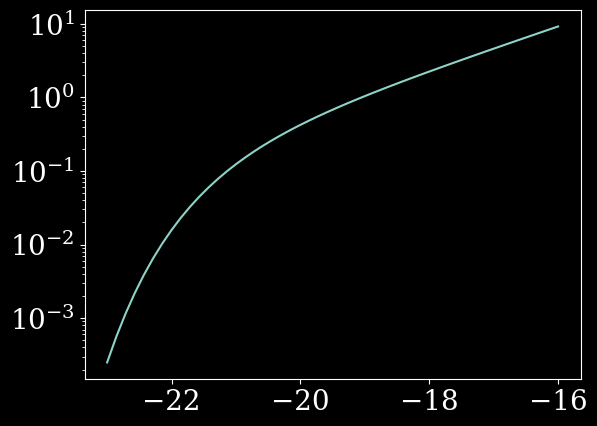

In [6]:
muv_range = np.linspace(-23, -16)
pmuv = p_muv(muv_range, phi_5, muv_star_5, alpha_5)
print(trapezoid(pmuv, muv_range))
plt.plot(muv_range, pmuv)
plt.yscale('log')
print('sum is probably wrong due to jacobian')

In [7]:
# measured lya properties from https://arxiv.org/pdf/2402.06070
MUV, MUV_err, z, ew_lya, ew_lya_err, dv_lya, dv_lya_err, fescA, \
    fescA_err, fescB, fescB_err, ID = np.load('./data/tang24.npy').T

In [8]:
lum_lya = (ew_lya/1215.67) * 2.47e15 * 10**(0.4*(51.6 - MUV))
lum_lya_err = lum_lya*np.sqrt((ew_lya_err/ew_lya)**2 + (np.exp(-0.4*np.log(10)*MUV_err)/MUV)**2)

In [9]:
lum_ha = lum_lya / 11.4 / fescA
lum_ha_err = lum_ha*np.sqrt((lum_lya_err/lum_lya)**2 + (fescA_err/fescA)**2)

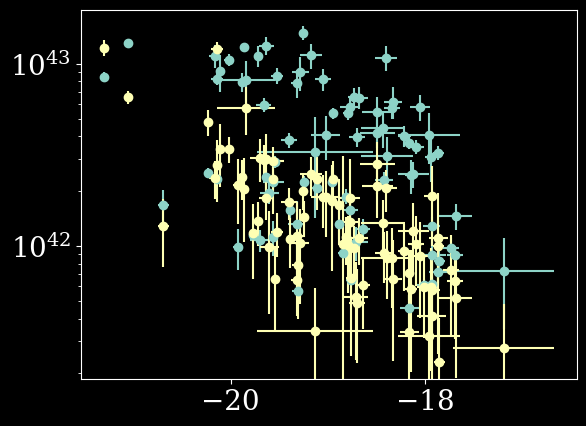

In [10]:
plt.errorbar(MUV, lum_lya, yerr=lum_lya_err, xerr=MUV_err, fmt='o', label='Tang et al. 2024')
plt.errorbar(MUV, lum_ha, yerr=lum_ha_err, xerr=MUV_err, fmt='o', label='Tang et al. 2024 (H-alpha)')
plt.yscale('log')
plt.show()

In [11]:
lum_flux_factor = 4*np.pi*(Planck18.luminosity_distance(5.0).to('cm').value)**2

In [12]:
wide = ID==0
_muv_wide = MUV[wide]
_muv_err_wide = MUV_err[wide]
_dv_lya_wide = dv_lya[wide]
_dv_lya_err_wide = dv_lya_err[wide]
_lum_lya_wide = lum_lya[wide]
_lum_lya_err_wide = lum_lya_err[wide]
_lum_ha_wide = lum_ha[wide]
_lum_ha_err_wide = lum_ha_err[wide]

deep = ID==1
_muv_deep = MUV[deep]
_muv_err_deep = MUV_err[deep]
_dv_lya_deep = dv_lya[deep]
_dv_lya_err_deep = dv_lya_err[deep]
_lum_lya_deep = lum_lya[deep]
_lum_lya_err_deep = lum_lya_err[deep]
_lum_ha_deep = lum_ha[deep]
_lum_ha_err_deep = lum_ha_err[deep]

In [13]:
muv_wide = np.zeros(len(_muv_wide)*1000)
lum_lya_wide = np.zeros_like(muv_wide)
dv_wide = np.zeros_like(muv_wide)
lum_ha_wide = np.zeros_like(muv_wide)

muv_deep = np.zeros(len(_muv_deep)*1000)
lum_lya_deep = np.zeros_like(muv_deep)
dv_deep = np.zeros_like(muv_deep)
lum_ha_deep = np.zeros_like(muv_deep)

In [14]:
for i, (muv, muve, lly, llye, dv, dve, lha, lhae) in enumerate(zip(_muv_wide, _muv_err_wide, _lum_lya_wide, _lum_lya_err_wide, \
                                                 _dv_lya_wide, _dv_lya_err_wide, _lum_ha_wide, _lum_ha_err_wide)):
    muv_wide[1000*i:1000*(i+1)] = np.random.normal(muv, muve, 1000)
    lum_lya_wide[1000*i:1000*(i+1)] = np.random.normal(lly, llye, 1000)
    dv_wide[1000*i:1000*(i+1)] = np.random.normal(dv, dve, 1000)
    lum_ha_wide[1000*i:1000*(i+1)] = np.random.normal(lha, lhae, 1000)
    
for i, (muv, muve, lly, llye, dv, dve, lha, lhae) in enumerate(zip(_muv_deep, _muv_err_deep, _lum_lya_deep, _lum_lya_err_deep, \
                                                 _dv_lya_deep, _dv_lya_err_deep, _lum_ha_deep, _lum_ha_err_deep)):
    muv_deep[1000*i:1000*(i+1)] = np.random.normal(muv, muve, 1000)
    lum_lya_deep[1000*i:1000*(i+1)] = np.random.normal(lly, llye, 1000)
    dv_deep[1000*i:1000*(i+1)] = np.random.normal(dv, dve, 1000)
    lum_ha_deep[1000*i:1000*(i+1)] = np.random.normal(lha, lhae, 1000)

This isn't perfect (we have lum<1) but we need to move on. Write the KDE.

In [15]:
from sklearn.decomposition import PCA

X = np.stack([muv_wide, lum_lya_wide, dv_wide, lum_ha_wide]).T
centers = X.mean(axis=0)
X_centered = X - centers

pca = PCA(n_components=4)  # Keeping all 4 dimensions
pca.fit(X_centered)

print("Principal Components:")
print(pca.components_.T)  # Each column is a principal component

Principal Components:
[[-1.29374620e-43 -2.29851422e-43  1.00000000e+00 -0.00000000e+00]
 [ 9.91743237e-01 -1.28239434e-01  9.88303882e-44 -5.54933235e-42]
 [ 5.58517910e-42 -8.00747947e-44  7.04175120e-85  1.00000000e+00]
 [ 1.28239434e-01  9.91743237e-01  2.44544521e-43 -6.36826573e-43]]


In [16]:
Y = pca.transform(X_centered)

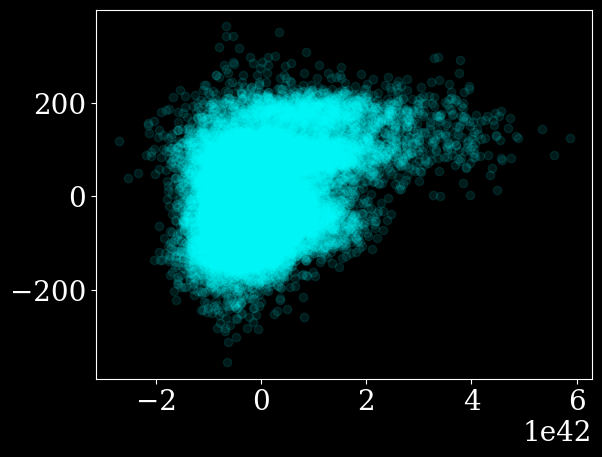

In [17]:
plt.scatter(Y[:,1], Y[:,3], alpha=0.1, color='cyan')
plt.show()

probability of detection given Llya, Lha, and equivalent width

In [18]:
def normal_cdf(x, mu=0):
    """
    Cumulative distribution function for a normal distribution.
    """
    return 0.5 * (1 + erf((x - mu + mu/5) / (mu/5 * np.sqrt(2))))

def p_obs(lly, lha, muv, mode='wide'):
    """
    Probability of observing a galaxy with given Lya luminosity, H-alpha luminosity, and UV magnitude.
    """
    # Convert luminosities to fluxes
    f_lya = lly / lum_flux_factor
    f_ha = lha / lum_flux_factor
    luv = 10**(0.4*(51.64 - muv))
    w_emerg = (1215.67/2.47e15)*(lly/luv)
    f_ha_lim = 2e-18  # H-alpha flux limit in erg/s/cm^2
    if mode == 'wide':
        w_lim = 80
        f_lya_lim = 2e-17
    elif mode == 'deep':
        w_lim = 8
        f_lya_lim = 2e-18
    p_lya = normal_cdf(f_lya, f_lya_lim)
    p_ha = normal_cdf(f_ha, f_ha_lim)
    p_w = normal_cdf(w_emerg, w_lim)
        
    return p_lya * p_ha * p_w

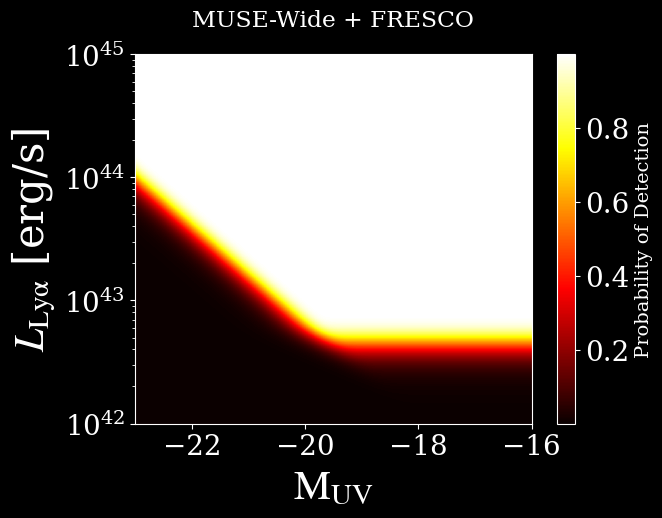

In [19]:
# for the actual paper we should frame this in terms of signal-to-noise ratios
# with a 100% chance of detection for SNR >= 5

llya_range = np.logspace(42, 45, 1000)
lha_range = np.logspace(40, 43, 1000)
muv_range = np.linspace(-23, -16, 1000)
_p = p_obs(llya_range[:,np.newaxis], 1e42, muv_range[np.newaxis,:], mode='wide')
plt.pcolormesh(muv_range, llya_range, _p, cmap='hot', shading='auto')
plt.colorbar(label='Probability of Detection')
# plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$L_\mathrm{Ly\alpha}$ [erg/s]', fontsize=font_size)
plt.xlabel(r'${\rm M}_\mathrm{UV}$', fontsize=font_size)
plt.title('MUSE-Wide + FRESCO', pad=20)
plt.show()

# First attempt at inference: no PCA

1. Fit multivariate gaussian to distribution of $(L_{\rm Ly\alpha}, L_{\rm H\alpha}, \Delta)$ for several ${\rm M}_{\rm UV}$ bins.
2. Apply selection and $P({\rm M}_{\rm UV})$ to the above fit
3. Fit functions to $\mu({\rm M}_{\rm UV})$ and $\sigma({\rm M}_{\rm UV})$

In [20]:
def multivar_normal_pdf(x, mu1, mu2, mu3, std1, std2, std3):
    """
    Multivariate normal probability density function.
    """
    coeff = 1 / (np.sqrt(2 * np.pi) ** 3 * std1 * std2 * std3)
    exponent = -0.5 * ((x[0] - mu1) ** 2 / std1 ** 2 + 
                       (x[1] - mu2) ** 2 / std2 ** 2 + 
                       (x[2] - mu3) ** 2 / std3 ** 2)
    return coeff * np.exp(exponent)

In [1]:

XWIDE = np.stack([np.log10(lum_lya_wide), dv_wide, np.log10(lum_ha_wide)])

all_params = np.zeros((20, 6))
for i, muv in enumerate(np.linspace(-20, -16, 20)):
    select = np.abs(muv_wide - muv) < 0.5
    XWIDE_MUV = XWIDE[:, select]
    _muv = muv_wide[select]

    def p_x(x, params):
        mu1, mu2, mu3, std1, std2, std3 = params
        _p_y = multivar_normal_pdf(x, mu1, mu2, mu3, std1, std2, std3)
        _p_muv = p_muv(_muv, phi_5, muv_star_5, alpha_5)
        _p_obs = p_obs(10**x[0], 10**x[2], _muv, mode='wide')
        plt.plot(_p_y, _p_muv)
        plt.show()
        breakpoint()
        return np.log10(_p_y) + np.log10(_p_muv) + np.log10(_p_obs)
    
    def loss(params):
        _p_x = p_x(XWIDE_MUV, params)

        return -1*np.sum(_p_x)
    
    print(loss(np.array([43, 100, 42, 0.5, 50, 0.5])))
    quit()
    
    res = minimize(loss, x0=np.array([43, 100, 42, 0.5, 50, 0.5]), method='Nelder-Mead')
    all_params[i, :] = res.x

NameError: name 'np' is not defined

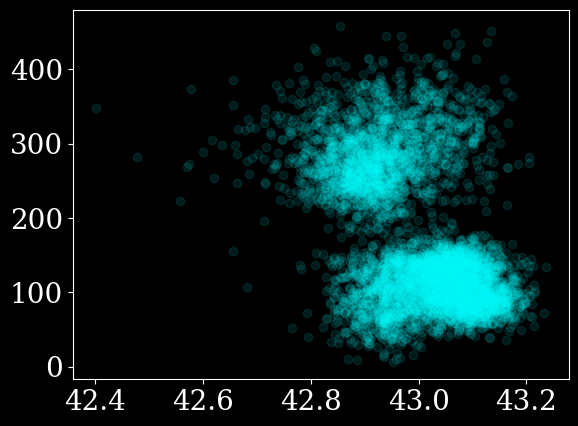

In [109]:
plt.scatter(XWIDE_muv[0], XWIDE_muv[1], color='cyan', alpha=0.1)
plt.show()